In [ ]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

#from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

from transformers import pipeline

c:\Users\ojoyc\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Load datasets
train_df = pd.read_csv("C:/Users/ojoyc/OneDrive/Documents/Repositories/Olivia_Joyce_Thesis/dataset/MELD-RAW/MELD.Raw/train_sent_emo.csv")
test_df = pd.read_csv("C:/Users/ojoyc/OneDrive/Documents/Repositories/Olivia_Joyce_Thesis/dataset/MELD-RAW/MELD.Raw/test_sent_emo.csv")
val_df = pd.read_csv("C:/Users/ojoyc/OneDrive/Documents/Repositories/Olivia_Joyce_Thesis/dataset/MELD-RAW/MELD.Raw/dev_sent_emo.csv")

#print(train_df.head())
#print(train_df.info())
#print(train_df.isnull().sum()) 
print(train_df['Emotion'].unique())
print(train_df['Sentiment'].unique())

['neutral' 'surprise' 'fear' 'sadness' 'joy' 'disgust' 'anger']
['neutral' 'positive' 'negative']


Feature Extraction can be done using embeddings or vectorisation
Bag of Words (below)
TF-IDF
or using pre-trained embeddings like BERT or GloVe for better performance

Why is the below feature extraction?
Tokenization: CountVectorizer splits (tokenizes) each text into words (tokens).
Feature Extraction: It then creates a vocabulary of all unique tokens (words) found in the training data.
For each text, it counts how many times each word from the vocabulary appears, creating a vector of word counts for each text.
These vectors are numerical features that represent the original text data, making it possible to use them as input for machine learning models.
The process transforms raw text into a structured, numerical format (feature vectors), 
fit_transform() (on training data):

fit: Scans all the training texts, finds all unique tokens, and builds the vocabulary.
transform: Converts the training texts into feature vectors using that vocabulary.
vectorizer.transform() (on test/validation data):

Uses the already built vocabulary from the training data to convert new texts into feature vectors.
No new words are added to the vocabulary at this stage.

**Bag of Words (CountVectorizer) vs. TF-IDF: Why use Bag of Words?**

**Bag of Words (BoW)** simply counts how many times each word appears in a document.  
**TF-IDF** (Term Frequency-Inverse Document Frequency) adjusts these counts by how common or rare a word is across all documents, down-weighting common words and up-weighting rare, informative words.

### Reasons to use Bag of Words (BoW) over TF-IDF:
- **Simplicity:** BoW is easier to understand and implement. It’s a good starting point for baseline models.
- **Speed:** BoW is computationally faster, especially on large datasets.
- **Interpretability:** The features (word counts) are more directly interpretable.
- **When word frequency matters:** If the absolute frequency of words is important for your task (e.g., spam detection, where repeated words are a signal), BoW may be more effective.
- **Small datasets:** On small datasets, TF-IDF can sometimes over-penalize common words, making BoW preferable.

### When to prefer TF-IDF:
- **When common words are not informative:** If your dataset contains many common words that don’t help distinguish between classes, TF-IDF helps reduce their impact.
- **When rare words are important:** TF-IDF highlights rare but important words.

**Summary:**  
Bag of Words is often used for its simplicity, speed, and interpretability, especially as a baseline. TF-IDF is preferred when you want to reduce the influence of common words and highlight rare, informative words. The best choice depends on your dataset and task—often, both are tried and compared in practice.

In [3]:
# Function to clean text
def clean_text(text):
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text) # Remove special characters
    text = text.lower() # Convert to lowercase
    return text

# Apply cleaning
train_df = train_df.copy()
train_df['Utterance'] = train_df['Utterance'].apply(clean_text)
test_df['Utterance'] = test_df['Utterance'].apply(clean_text)
val_df['Utterance'] = val_df['Utterance'].apply(clean_text)

# Feature Extraction using TF-IDF
#  fit the TfidfVectorizer only on training data then transform train, test, and validation data
tfidf_vectorizer = TfidfVectorizer()
X_train = tfidf_vectorizer.fit_transform(train_df['Utterance'])
X_test = tfidf_vectorizer.transform(test_df['Utterance'])
X_val = tfidf_vectorizer.transform(val_df['Utterance'])
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

# Encode Labels. Convert Categorical labels (Emotion and Sentiment) to numerical format
# Fit the LabelEncoder on only training data then transform train, test, and validation data
emotion_encoder = LabelEncoder()
sentiment_encoder = LabelEncoder()

y_train_emotion = emotion_encoder.fit_transform(train_df['Emotion'])
y_train_sentiment = sentiment_encoder.fit_transform(train_df['Sentiment'])

y_test_emotion = emotion_encoder.transform(test_df['Emotion'])
y_test_sentiment = sentiment_encoder.transform(test_df['Sentiment'])
y_val_emotion = emotion_encoder.transform(val_df['Emotion'])
y_val_sentiment = sentiment_encoder.transform(val_df['Sentiment'])

(9989, 5870)
(2610, 5870)
(1109, 5870)


In [ ]:
#Train a ML model for emotion & sentiment classification 
# Train a Random Forest classifier
emotion_model = RandomForestClassifier()
emotion_model.fit(X_train, y_train_emotion)

# Predict on the test set
y_pred_emotion = emotion_model.predict(X_test)

# Evaluate the model
print(classification_report(y_test_emotion, y_pred_emotion, target_names=emotion_encoder.classes_))

#Train a Random Forest classifier for sentiment classification
sentiment_model = RandomForestClassifier()
sentiment_model.fit(X_train, y_train_sentiment)

# Predict on the test set
y_pred_sentiment = sentiment_model.predict(X_test)

# Evaluate the model
print("Sentiment Classification Report:")
print(classification_report(y_test_sentiment, y_pred_sentiment, target_names=sentiment_encoder.classes_))

              precision    recall  f1-score   support

       anger       0.39      0.06      0.11       345
     disgust       0.40      0.03      0.05        68
        fear       0.17      0.02      0.04        50
         joy       0.54      0.19      0.28       402
     neutral       0.53      0.93      0.68      1256
     sadness       0.57      0.06      0.11       208
    surprise       0.58      0.36      0.44       281

    accuracy                           0.53      2610
   macro avg       0.45      0.24      0.24      2610
weighted avg       0.51      0.53      0.44      2610

Sentiment Classification Report:
              precision    recall  f1-score   support

    negative       0.55      0.34      0.42       833
     neutral       0.56      0.83      0.66      1256
    positive       0.57      0.24      0.34       521

    accuracy                           0.56      2610
   macro avg       0.56      0.47      0.48      2610
weighted avg       0.56      0.56      0.52 

Next steps 
1. Optimise the model use hyperparameter tuning e.g. GridSearchCV to improve model performance
2. experiment with more advanced models like BERT, RoBERTa or GPT for better performance. Use Hugging Face 'pipeline'
-If you want even better performance, you can fine-tune these models on your dataset using Hugging Face’s Trainer API, but this requires more code and GPU resources.
3. Incorporate Multi-Modality - add audio and visual features to the model for multi-modal emotion/sentiment recognition
4. Evaluation on validation set


In [9]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Grid search for emotion classification
grid_rf = GridSearchCV(RandomForestClassifier(), param_grid, cv=3, scoring='f1_weighted', n_jobs=-1)
grid_rf.fit(X_train, y_train_emotion)

print("Best parameters:", grid_rf.best_params_)
best_rf = grid_rf.best_estimator_

# Predict and evaluate on validation set
y_val_pred = best_rf.predict(X_val)
print("Validation Set Classification Report:")
print(classification_report(y_val_emotion, y_val_pred, target_names=emotion_encoder.classes_))

# (Optional) Predict and evaluate on test set after validation
y_test_pred = best_rf.predict(X_test)
print("Test Set Classification Report:")
print(classification_report(y_test_emotion, y_test_pred, target_names=emotion_encoder.classes_))

Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Validation Set Classification Report:
              precision    recall  f1-score   support

       anger       0.39      0.05      0.08       153
     disgust       1.00      0.05      0.09        22
        fear       1.00      0.03      0.05        40
         joy       0.44      0.14      0.21       163
     neutral       0.47      0.93      0.62       470
     sadness       0.85      0.10      0.18       111
    surprise       0.46      0.28      0.35       150

    accuracy                           0.47      1109
   macro avg       0.66      0.22      0.23      1109
weighted avg       0.52      0.47      0.37      1109

Test Set Classification Report:
              precision    recall  f1-score   support

       anger       0.42      0.06      0.10       345
     disgust       0.40      0.03      0.05        68
        fear       0.17      0.02      0.04        50
         jo

In [10]:
from sklearn.linear_model import LogisticRegression

# Train Logistic Regression for emotion classification
logreg_emotion = LogisticRegression(max_iter=1000)
logreg_emotion.fit(X_train, y_train_emotion)
y_pred_emotion_lr = logreg_emotion.predict(X_test)
print("Logistic Regression Emotion Classification Report:")
print(classification_report(y_test_emotion, y_pred_emotion_lr, target_names=emotion_encoder.classes_))

# Train Logistic Regression for sentiment classification
logreg_sentiment = LogisticRegression(max_iter=1000)
logreg_sentiment.fit(X_train, y_train_sentiment)
y_pred_sentiment_lr = logreg_sentiment.predict(X_test)
print("Logistic Regression Sentiment Classification Report:")
print(classification_report(y_test_sentiment, y_pred_sentiment_lr, target_names=sentiment_encoder.classes_))

Logistic Regression Emotion Classification Report:
              precision    recall  f1-score   support

       anger       0.31      0.08      0.13       345
     disgust       1.00      0.01      0.03        68
        fear       0.67      0.04      0.08        50
         joy       0.49      0.21      0.30       402
     neutral       0.54      0.90      0.67      1256
     sadness       0.47      0.09      0.15       208
    surprise       0.51      0.38      0.43       281

    accuracy                           0.52      2610
   macro avg       0.57      0.24      0.25      2610
weighted avg       0.51      0.52      0.45      2610

Logistic Regression Sentiment Classification Report:
              precision    recall  f1-score   support

    negative       0.54      0.40      0.46       833
     neutral       0.57      0.77      0.65      1256
    positive       0.52      0.28      0.36       521

    accuracy                           0.55      2610
   macro avg       0.54    

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Example: Simple feedforward neural network for emotion classification
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(emotion_encoder.classes_), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train.toarray(), y_train_emotion, epochs=10, batch_size=32, validation_data=(X_val.toarray(), y_val_emotion))

# Evaluate
loss, acc = model.evaluate(X_test.toarray(), y_test_emotion)
print(f"Test accuracy: {acc:.2f}")

c:\Users\ojoyc\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.4853 - loss: 1.4872 - val_accuracy: 0.4626 - val_loss: 1.4799
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5591 - loss: 1.2209 - val_accuracy: 0.4680 - val_loss: 1.4827
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6570 - loss: 0.9783 - val_accuracy: 0.4445 - val_loss: 1.5508
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.7374 - loss: 0.7683 - val_accuracy: 0.4454 - val_loss: 1.6840
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.7954 - loss: 0.6116 - val_accuracy: 0.4319 - val_loss: 1.8846
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.8326 - loss: 0.4964 - val_accuracy: 0.4292 - val_loss: 1.9782
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.8611 - loss: 0.4199 - val_accuracy: 0.4364 - val_loss: 2.1637
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.8775 - loss: 0.3671 - val_accu

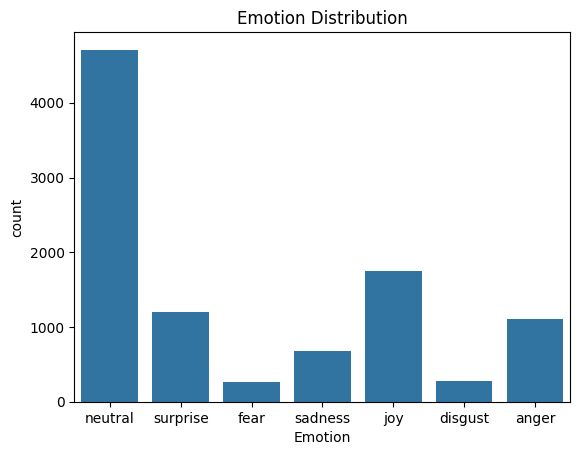

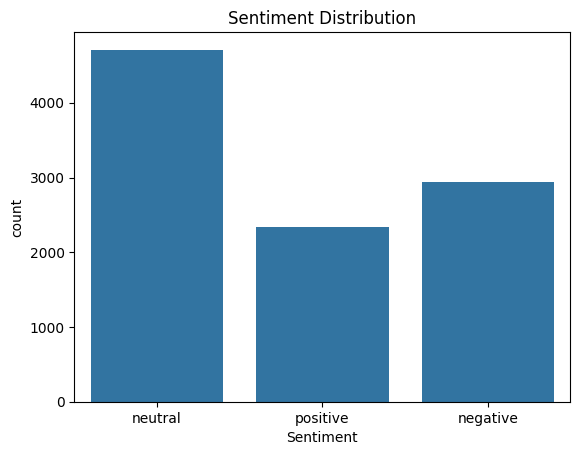

In [8]:
sns.countplot(data=train_df, x='Emotion')
plt.title("Emotion Distribution")
plt.show()

sns.countplot(data=train_df, x='Sentiment')
plt.title("Sentiment Distribution")
plt.show()

Below uses the pretrained text model BERT for emotion and sentiment classification. 
Use CLIP or Flamingo for multi-modal

In [ ]:
from transformers import pipeline

# Load a pre-trained sentiment analysis pipeline
# Emotion classification with BERT
emotion_pipeline = pipeline("text-classification", model="bhadresh-savani/bert-base-uncased-emotion")
# Sentiment classification with DistilBERT 
sentiment_pipeline = pipeline("text-classification", model="distilbert-base-uncased-finetuned-sst-2-english")
# Sentiment classification with RoBERTa
sentiment_pipeline2 = pipeline("text-classification", model="cardiffnlp/twitter-roberta-base-sentiment-latest")

c:\Users\ojoyc\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device set to use cpu
Device set to use cpu


In [5]:
# Test emotion and sentiment prediction on actual texts from your test set
sample_texts = test_df['Utterance'].head(5)  # Change 5 to any number of samples you want to test

for text in sample_texts:
    emotion_result = emotion_pipeline(text)
    sentiment_result = sentiment_pipeline(text)
    print(f"Text: {text}")
    print("Predicted Emotion:", emotion_result)
    print("Predicted Sentiment:", sentiment_result)
    print("-" * 50)

Text: why do all youre coffee mugs have numbers on the bottom
Predicted Emotion: [{'label': 'anger', 'score': 0.8396331071853638}]
Predicted Sentiment: [{'label': 'NEGATIVE', 'score': 0.9980782270431519}]
--------------------------------------------------
Text: oh thats so monica can keep track that way if one on them is missing she can be like wheres number 27
Predicted Emotion: [{'label': 'sadness', 'score': 0.9964519739151001}]
Predicted Sentiment: [{'label': 'NEGATIVE', 'score': 0.9966804385185242}]
--------------------------------------------------
Text: yknow what
Predicted Emotion: [{'label': 'anger', 'score': 0.8144062757492065}]
Predicted Sentiment: [{'label': 'POSITIVE', 'score': 0.5339961647987366}]
--------------------------------------------------
Text: come on lydia you can do it
Predicted Emotion: [{'label': 'joy', 'score': 0.9449968934059143}]
Predicted Sentiment: [{'label': 'POSITIVE', 'score': 0.999315619468689}]
--------------------------------------------------
Text

In [ ]:
# emotion_result = emotion_pipeline(example_text)
# sentiment_result = sentiment_pipeline(example_text)
# print("Emotion:", emotion_result)
# print("Sentiment:", sentiment_result)